In [1]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt

In [2]:

with open("corpus_0001.clean.asl.txt", encoding="utf8") as f:
    linesASL = f.read().split("\n")[:-1]
with open("corpus_0001.clean.en.txt", encoding="utf8") as f:
    linesEN = f.read().split("\n")[:-1]


In [3]:
print(len(linesASL))
print(len(linesEN))

1060672
1060672


In [4]:

text_pairs = []
for i in range(len(linesASL)):
    glosa = "[start] " + linesASL[i] + " [end]"
    text_pairs.append((linesEN[i], glosa))

In [5]:
len(text_pairs)

1060672

In [6]:
for _ in range(5):
    print(random.choice(text_pairs))

('THIS SILENCE COULD NOT CONTINUE LONG WITHOUT ATTRACTING THE ATTENTION OF THE REST OF THE PARTY ; UPON WHICH MR ARNOLD SAID :', '[start]  THIS SILENCE COULD NOT CONTINUE LONG WITHOUT ATTRACTING ATTENTION-REST-PARTY UPON WHICH MR ARNOLD SAID  [end]')
('BUT I SAY   HERE WITHAL IS ONE NOT PHANTASMAL ; OF INDISPUTABLE CERTAINTY   HOME-GROWN   JUST COMMENCING BUSINESS   WHO CARRIED IT FAR !', '[start]  BUT PRO-1 SAY HERE WITHALBEONE NOT PHANTASMAL -INDISPUTABLE CERTAINTY HOME-GROWN JUST COMMENCING BUSINESS wh-q(who)CARRIED PRO-3(it) FAR  [end]')
('" SI LES MALADE TOUSSE IL USERA SOIT DE JOUR SOIT DE NUIT PAR PETITES CUILLEREES A CASSE D  UN LOOCH   QUI SERA FAIT AVEC UN ONCE DE SYROP DE VIOLAT ET UN DRAGME DE BLANC DE BALEINE ', '[start]  SI LES MALADE TOUSSE IL USERA SOIT DE JOUR SOIT DE NUIT PAR PETITES CUILLEREES CASSE UN LOOCH QUI SERA FAIT AVEC UN ONCE DE SYROP DE VIOLAT ET UN DRAGME DE BLANC DE BALEINE  [end]')
('I WROTE TO YOU LAST WEEK   ASKING YOU TO VISIT ME ', '[start]  PRO-1 WR

In [7]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

1060672 total pairs
742472 training pairs
159100 validation pairs
159100 test pairs


In [8]:
vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return lowercase


eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
asl_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_asl_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
asl_vectorization.adapt(train_asl_texts)

In [9]:
def format_dataset(eng, asl):
    eng = eng_vectorization(eng)
    asl = asl_vectorization(asl)
    return ({"encoder_inputs": eng, "decoder_inputs": asl[:, :-1],}, asl[:, 1:])


def make_dataset(pairs):
    eng_texts, asl_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    asl_texts = list(asl_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, asl_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [10]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


In [12]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [15]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [16]:
encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, None)]           0         
                                                                 
 positional_embedding_2 (Pos  (None, None, 256)        3845120   
 itionalEmbedding)                                               
                                                                 
 transformer_encoder_1 (Tran  (None, None, 256)        3155456   
 sformerEncoder)                                                 
                                                                 
Total params: 7,000,576
Trainable params: 7,000,576
Non-trainable params: 0
_________________________________________________________________


In [17]:
decoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_3 (Positi  (None, None, 256)   3845120     ['decoder_inputs[0][0]']         
 onalEmbedding)                                                                                   
                                                                                                  
 decoder_state_inputs (InputLay  [(None, None, 256)]  0          []                               
 er)                                                                                              
                                                                                            

In [18]:
epochs = 10  # This should be at least 30 for convergence
transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_2 (Positi  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 onalEmbedding)                                                                                   
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_1 (Transfo  (None, None, 256)   3155456     ['positional_embedding_

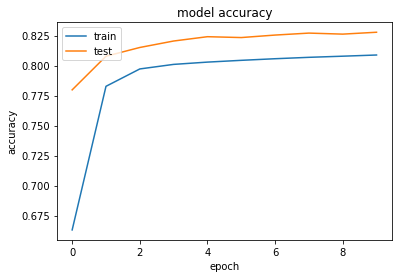

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

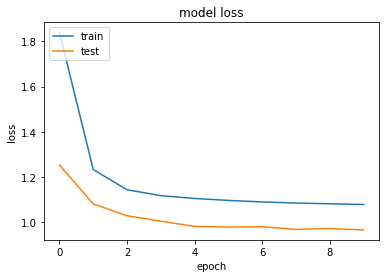

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
transformer.evaluate(val_ds, verbose=1)

2486/2486 [==============================] - 51s 20ms/step - loss: 0.9656 - accuracy: 0.8277


[0.9656355381011963, 0.8277386426925659]

In [35]:
asl_vocab = asl_vectorization.get_vocabulary()
asl_index_lookup = dict(zip(range(len(asl_vocab)), asl_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    sequence = []
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = asl_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = asl_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        sequence.append(sampled_token)
        if sampled_token == "[end]":
            sequence.pop()
            break
    return sequence


test_eng_texts = [pair[0] for pair in test_pairs]
test_asl_texts = [pair[1] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(translated)

['[UNK]', 'said', 'kim', 'and', 'held', 'poss-3(he)', 'tongue']
['just', 'because', '[UNK]']
['frank', '[UNK]', 'ahead', 'turning', 'to', 'pro-3(he)', 'hours']
['and', 'yet', 'god', 'wot', 'poss-1', '[UNK]', 'about', 'and', '[UNK]', 'many', '[UNK]', '[UNK]', 'especially', 'company', 'say', 'that', 'pro-1', 'have', '[UNK]', '[UNK]']
['mighty', '[UNK]', '[UNK]', 'let', 'this', 'poss-1', 'history', 'become', 'famous', 'throughout', 'world']
['boston', 'april', '[UNK]', '[UNK]']
['if', 'pro-3(he)', 'cannot', 'breakfast', 'to', 'pay', 'for', 'sugar', 'pro-3(he)', 'must', 'go', 'without', 'sugar']
['pro-1', 'knew', 'too', 'that', '[UNK]', 'time', 'in', 'entire', '[UNK]', 'that', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]']
['had', 'an', 'accident', 'then', 'happened', '[UNK]', 'kind', 'never', 'by', 'these', 'beasts', 'would', 'have', 'been', 'in', 'most', '[UNK]', '[UNK]', '[UNK]', '[UNK]']
['[UNK]', 'thee', 'gentle']
['pro-1', 'lingered', 'some'

In [25]:
from nltk.translate.bleu_score import sentence_bleu

In [29]:
print(len(test_eng_texts))

159100


In [63]:

#TODO otimizar. demora aprox 24hrs analizar 159100
def shapeBLEUReference(string):
    unfiltered = string.lower().replace("[start]", "").replace("[end]","").split(" ")
    return list(filter(lambda text: text != '' and text != ' ', unfiltered))


bleu1 = 0
bleu2 = 0
bleu3 = 0
bleu4 = 0

total = len(test_asl_texts)
for i in range(10):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    reference = [shapeBLEUReference(test_asl_texts[i])]
    print(reference)
    print(translated)
    

for i in range(total):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    reference = [shapeBLEUReference(test_spa_texts[i])]
    b1 = sentence_bleu(reference, translated, weights=(1, 0, 0, 0))
    b2 = sentence_bleu(reference, translated, weights=(0.5, 0.5, 0, 0))
    b3 = sentence_bleu(reference, translated, weights=(0.33, 0.33, 0.33, 0))
    b4 = sentence_bleu(reference, translated, weights=(0.25, 0.25, 0.25, 0.25))
    bleu1 += b1
    bleu2 += b2
    bleu3 += b3
    bleu4 += b4
    
print(bleu1/total)
print(bleu2/total)
print(bleu3/total)
print(bleu4/total)
    
    


[['poss-1', 'lord', 'approaches']]
['poss-1', 'lord', 'approaches']
[['mr', 'andrews', 'experience', 'and', 'vision-lord', 'lyttelton', 'beboth', 'printed', 'in', 'scots', 'magazine', 'december', '1779']]
['mr', '[UNK]', 'experience', 'and', '[UNK]', '[UNK]', 'printed', 'in', '[UNK]', 'magazine', 'december', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]']
[['sir', 'pro-1(we)belegislators', 'not', 'antiquaries']]
['sir', '[UNK]', 'not', '[UNK]']
[['law', 'section', '735', '6th', 'ed']]
['law', 'section', '[UNK]', 'rhine', '[UNK]']
[['wh-q(why)did', 'father', 'kill', 'sheep']]
['[UNK]', 'kill', 'sheep']
[['that', 'night', 'mr', 'cooper', 'poss-3(they)', 'master', 'beto', 'attend', 'party', 'and', 'thisbeposs-3(they)', 'opportunity']]
['that', 'night', 'mr', '--', '--', 'mr', '[UNK]', 'attend', 'party', 'and', 'this', '[UNK]', 'looking']
[['pro-3(he)', 'longedbealone', 'to', 'recover', 'himself']]
['pro-3(he)', '[UNK]', 'to', 'world', 'himself']
[['mrs', '